### Objective: 
Predict the probability of a stroke based on patient-level data

### Expected outcome: 
In this notebook, I am to produce a classification model that yields the probability of a stroke


### Data source: 
The dataset came from [**Kaggle**](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data), with its actual source remaining confidential as of writing.

In [1]:
import pandas as pd
df_stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [2]:
data_info = pd.DataFrame(df_stroke.dtypes, columns=['Dtype'])
data_info['Unique'] = df_stroke.nunique().values
data_info['Null'] = df_stroke.isnull().sum().values
data_info

,Dtype,Unique,Null
id,int64,5110,0
gender,object,3,0
age,float64,104,0
hypertension,int64,2,0
heart_disease,int64,2,0
ever_married,object,2,0
work_type,object,5,0
Residence_type,object,2,0
avg_glucose_level,float64,3979,0
bmi,float64,418,201


The dataset has 5110 entries. The target variable is stroke: 1 for yes, 0 for no. There are 12 columns, 4 of which are numeric: `id`, `age`, `avg_glucose_level`, and `bmi`. But note that `id` is a unique identifier, akin to a patient number, and does not provide predictive value for the target variable and can be safely disregarded throughout the modeling. There are 9 categorical varaibles, including the target variable. 

The table `data_info` lists down the variables used in the dataset. This table shows that all but `bmi` have non-null entries. I will be imputing the null entries in `bmi` with the mean of non-null entries of `bmi`

In [3]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the 'bmi' column
df_stroke['bmi'] = imputer.fit_transform(df_stroke[['bmi']])

In [4]:
# Check if 'bmi' column still has null entries
df_stroke['bmi'].isnull().sum()

0

Success! There are no more null values! Next, I list down the unique values of all columns in the stroke dataset `df_stroke`.

In [5]:
for i in df_stroke.columns:
    print(f'Unique elements in {i}: {df_stroke[i].unique()}')

Unique elements in id: [ 9046 51676 31112 ... 19723 37544 44679]
Unique elements in gender: ['Male' 'Female' 'Other']
Unique elements in age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 

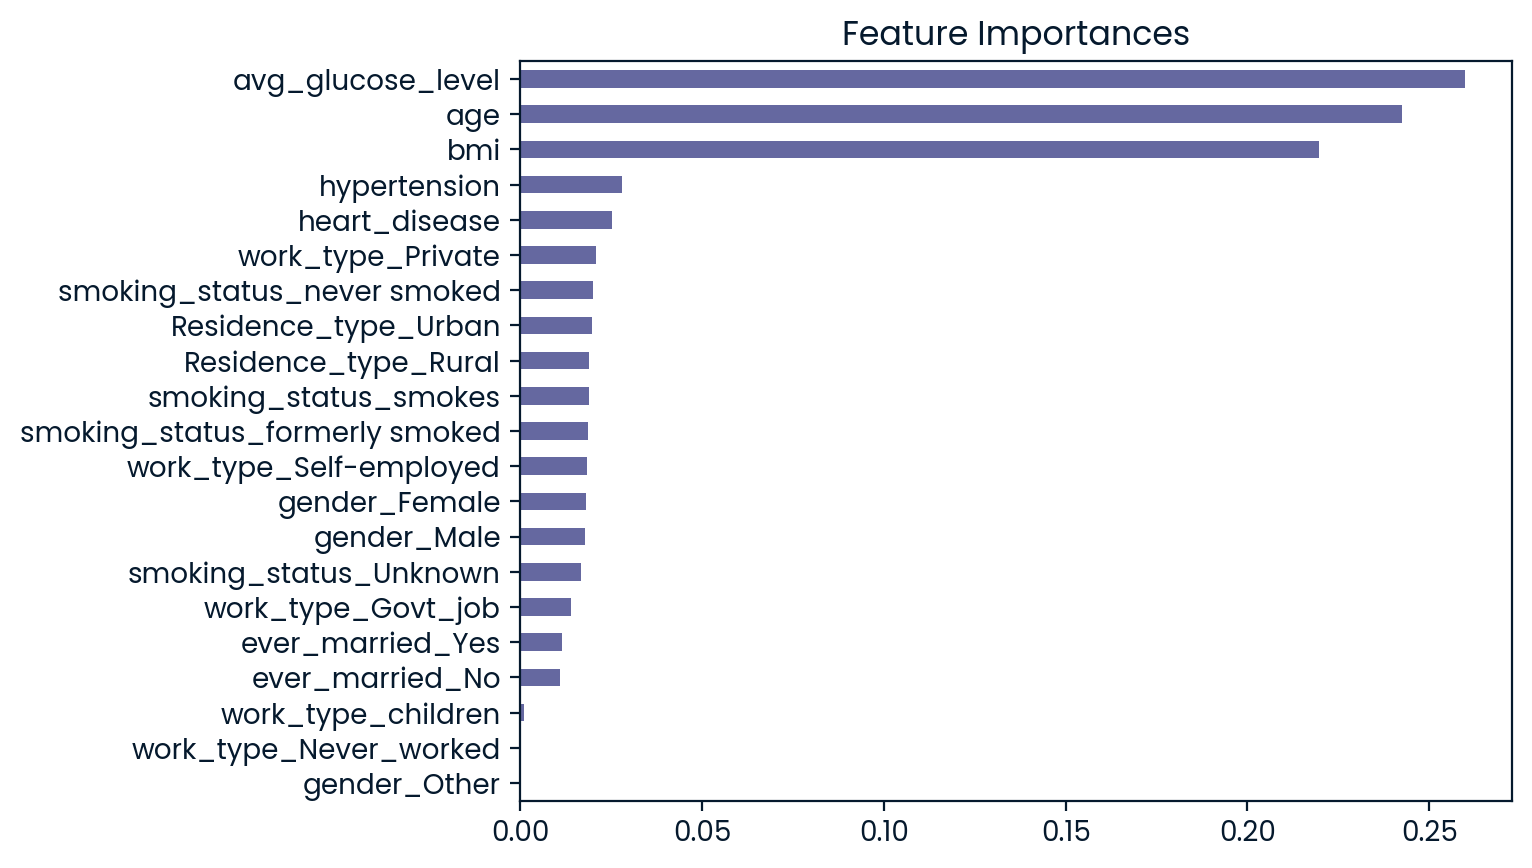

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt, numpy as np

# Define features and target
X = df_stroke.drop(['stroke', 'id'], axis=1)
y = df_stroke['stroke']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create a ColumnTransformer with StandardScaler for numerical columns and OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Create a pipeline with the preprocessor and RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, ohe_feature_names])



# Get feature importances from the RandomForestClassifier
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Combine numerical and categorical feature names
features = numerical_cols.tolist() + pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

# Create a DataFrame for feature importances
importances = pd.Series(feature_importances, index=features)

# Get the top 10 features
n_top=10
top_features = importances.nlargest(n_top).index.tolist()

# Plot feature importances
importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()



In [16]:
import copy
pipeline_copy = copy.deepcopy(pipeline)

del pipeline_copy.steps[-1]


In [17]:
X_transformed = pipeline_copy.transform(X)


X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)


X_transformed_top_df = X_transformed_df[top_features]
X_transformed_top_df.head(1)

,avg_glucose_level,age,bmi,hypertension,heart_disease,work_type_Private,smoking_status_never smoked,Residence_type_Urban,Residence_type_Rural,smoking_status_smokes
0,2.704126,1.04659,0.989465,-0.327962,4.18303,1.0,0.0,1.0,0.0,0.0


In [18]:
y_train.shape

(4088,)

In [22]:
# from sklearn.compose import make_column_selector

# # Create a new ColumnTransformer to include only the top 10 features
# top_preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols), #[col for col in top_features if col in numerical_cols]),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)#[col for col in top_features if col in categorical_cols])
#     ],
#     remainder='drop'
# )



# # Transform the training and testing data to include only the top features
# X_train_top = top_preprocessor.fit_transform(X_train)
# X_test_top = top_preprocessor.transform(X_test)

In [19]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable


In [20]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

# Define the search spaces for each model
search_spaces = {
    'xgb': {
        'classifier__n_estimators': Integer(50, 500),
        'classifier__max_depth': Integer(3, 10),
        'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform')
    },
    'lgbm': {
        'classifier__n_estimators': Integer(50, 500),
        'classifier__max_depth': Integer(3, 10),
        'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform')
    },
    'svm': {
        'classifier__C': Real(1e-6, 1e+6, prior='log-uniform'),
        'classifier__gamma': Real(1e-6, 1e-1, prior='log-uniform')
    },
    'adaboost': {
        'classifier__n_estimators': Integer(50, 500),
        'classifier__learning_rate': Real(0.01, 1.0, prior='log-uniform')
    }
}

# Define the models
models = {
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'lgbm': LGBMClassifier(random_state=42, verbose=-1),
    'svm': SVC(random_state=42),
    'adaboost': AdaBoostClassifier(random_state=42)
}

# Perform Bayesian optimization for each model
best_params = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    opt = BayesSearchCV(
        estimator=pipeline,
        search_spaces=search_spaces[model_name],
        n_iter=5,
        cv=3,
        n_jobs=-1,
        random_state=42
    )
    
    opt.fit(X_train, y_train)
    best_params[model_name] = opt.best_params_
    print(f"Best parameters for {model_name}: {opt.best_params_}")

Best parameters for xgb: OrderedDict([('classifier__learning_rate', 0.045401641878176635), ('classifier__max_depth', 9), ('classifier__n_estimators', 97)])
Best parameters for lgbm: OrderedDict([('classifier__learning_rate', 0.045401641878176635), ('classifier__max_depth', 9), ('classifier__n_estimators', 97)])
Best parameters for svm: OrderedDict([('classifier__C', 0.08341564384216595), ('classifier__gamma', 0.004351397079152049)])
Best parameters for adaboost: OrderedDict([('classifier__learning_rate', 0.06610098295419149), ('classifier__n_estimators', 377)])


In [47]:
best_params

{'xgb': OrderedDict([('classifier__learning_rate', 0.045401641878176635),
              ('classifier__max_depth', 9),
              ('classifier__n_estimators', 97)]),
 'lgbm': OrderedDict([('classifier__learning_rate', 0.045401641878176635),
              ('classifier__max_depth', 9),
              ('classifier__n_estimators', 97)]),
 'svm': OrderedDict([('classifier__C', 0.08341564384216595),
              ('classifier__gamma', 0.004351397079152049)]),
 'adaboost': OrderedDict([('classifier__learning_rate', 0.06610098295419149),
              ('classifier__n_estimators', 377)])}

In [21]:
from sklearn.model_selection import cross_val_score
import numpy as np


# # Transform the training and testing data to include only the top features
# X_top = top_preprocessor.transform(X)


average_accuracies = {}
for model_name, model in models.items(): #best_models.items():
    
    
    best_hyperparameters = {q.split('__')[1]:r for q,r in best_params[model_name].items()}
    
    model.set_params(**best_hyperparameters)
    
    pipeline = Pipeline(steps=[
        ('classifier', model)
    ])
    
    # Perform 5-fold cross-validation
    accuracies = cross_val_score(pipeline, X_transformed_top_df, y, cv=5, scoring='accuracy')
    # if model_name=='xgb': print(accuracies)
    average_accuracies[model_name] = np.mean(accuracies)
    print(f"Average accuracy for {model_name}: {average_accuracies[model_name]:.4f}")

# Find the best model based on the highest average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
print(f"The best model is {best_model_name} with average accuracy of {average_accuracies[best_model_name]}.")

Average accuracy for xgb: 0.9468
Average accuracy for lgbm: 0.9491
Average accuracy for svm: 0.9513
Average accuracy for adaboost: 0.9513
The best model is svm with average accuracy of 0.9512720156555773.


### next: WRAP IT UP AS A FUNCTION

In [13]:
# import pandas as pd, numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# import matplotlib.pyplot as plt


# def get_top_features(df, tsplit=0.2, rand_seed=42, get_top=(True, 10), drop_cols = ['stroke', 'id'], target='stroke'):



#     # Define features and target
#     X = df.drop(drop_cols, axis=1)
#     y = df[target]

#     # Identify categorical and numerical columns
#     categorical_cols = X.select_dtypes(include=['object', 'category']).columns
#     numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns

#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsplit, stratify=y, random_state=rand_seed)

#     # Create a ColumnTransformer with StandardScaler for numerical columns and OneHotEncoder for categorical columns
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(), numerical_cols),
#             ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#         ]
#     )
    
    

#     # Create a pipeline with the preprocessor and RandomForestClassifier
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('classifier', RandomForestClassifier(random_state=rand_seed))
#     ])
    
    
#     ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
#     feature_names = np.concatenate([numerical_cols, ohe_feature_names])
    

#     # Fit the pipeline on the training data
#     pipeline.fit(X_train, y_train)


#     ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
#     feature_names = np.concatenate([numerical_cols, ohe_feature_names])



#     # Get feature importances from the RandomForestClassifier
#     feature_importances = pipeline.named_steps['classifier'].feature_importances_

#     # Combine numerical and categorical feature names
#     features = numerical_cols.tolist() + pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

#     # Create a DataFrame for feature importances
#     importances = pd.Series(feature_importances, index=features)
#     ans = importances

    
#     if get_top[0]==True:
#         # Get the top get_top[1] features
#         top_features = importances.nlargest(get_top[1])#.index.tolist()
#         ans=top_features

        
#     return ans, pipeline, preprocessor, X, y, feature_names




# # feat, pipeline, preprocessor = get_top_features(df_stroke, tsplit=0.2, rand_seed=42, get_top=(True, 10), drop_cols = ['stroke', 'id'], target='stroke')




# # # Plot feature importances
# # plt.clf()
# # ax = feat.sort_values().plot(kind='barh')
# # for index,value in enumerate(feat.sort_values()):
# #     ax.text(0.98*value, index, f'{value:.2f}', ha='right', va='center', color='white',fontsize=10)
# # ax.set_title('Feature Importances')
# # plt.show()


# def get_best_model(df_stroke, tsplit=0.2, rand_seed=42, get_top=(True, 10), drop_cols = ['stroke', 'id'], target='stroke', num_samp = 5, niter = 10):
    
    
#     feat, pipeline, preprocessor, X, y, feature_names = get_top_features(df_stroke, tsplit, rand_seed, get_top, drop_cols, target)
    

#     import copy
#     pipeline_copy = copy.deepcopy(pipeline)
#     del pipeline_copy.steps[-1]


#     X_transformed = pipeline_copy.transform(X)


#     X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)


#     X_transformed_top_df = X_transformed_df[top_features]
#     X_transformed_top_df.head(1)





#     from skopt import BayesSearchCV
#     from skopt.space import Real, Integer, Categorical
#     from sklearn.svm import SVC
#     from xgboost import XGBClassifier
#     from lightgbm import LGBMClassifier
#     from sklearn.ensemble import AdaBoostClassifier

#     # Define the search spaces for each model
#     search_spaces = {
#         'xgb': {
#             'classifier__n_estimators': Integer(50, 500),
#             'classifier__max_depth': Integer(3, 10),
#             'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform')
#         },
#         'lgbm': {
#             'classifier__n_estimators': Integer(50, 500),
#             'classifier__max_depth': Integer(3, 10),
#             'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform')
#         },
#         'svm': {
#             'classifier__C': Real(1e-6, 1e+6, prior='log-uniform'),
#             'classifier__gamma': Real(1e-6, 1e-1, prior='log-uniform')
#         },
#         'adaboost': {
#             'classifier__n_estimators': Integer(50, 500),
#             'classifier__learning_rate': Real(0.01, 1.0, prior='log-uniform')
#         }
#     }

#     # Define the models
#     models = {
#         'xgb': XGBClassifier(random_state=rand_seed, use_label_encoder=False, eval_metric='logloss'),
#         'lgbm': LGBMClassifier(random_state=rand_seed, verbose=-1),
#         'svm': SVC(random_state=rand_seed),
#         'adaboost': AdaBoostClassifier(random_state=rand_seed)
#     }

#     # Perform Bayesian optimization for each model
#     best_params = {}
#     for model_name, model in models.items():
#         pipeline = Pipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('classifier', model)
#         ])

#         opt = BayesSearchCV(
#             estimator=pipeline,
#             search_spaces=search_spaces[model_name],
#             n_iter=niter,
#             cv=3,
#             n_jobs=-1,
#             random_state=rand_seed
#         )

#         opt.fit(X_train, y_train)
#         best_params[model_name] = opt.best_params_
#         # print(f"Best parameters for {model_name}: {opt.best_params_}")


#     from sklearn.model_selection import cross_val_score
#     import numpy as np


#     # # Transform the training and testing data to include only the top features
#     # X_top = top_preprocessor.transform(X)


#     average_accuracies = {}
#     for model_name, model in models.items(): #best_models.items():


#         best_hyperparameters = {q.split('__')[1]:r for q,r in best_params[model_name].items()}

#         model.set_params(**best_hyperparameters)

#         pipeline = Pipeline(steps=[
#             ('classifier', model)
#         ])

#         # Perform num_samp-fold cross-validation
#         accuracies = cross_val_score(pipeline, X_transformed_top_df, y, cv=num_samp, scoring='accuracy')
#         average_accuracies[model_name] = np.mean(accuracies)
#         print(f"Average accuracy for {model_name}, num_features={len(feat)}: {average_accuracies[model_name]:.4f}")

#     # Find the best model based on the highest average accuracy
#     best_model_name = max(average_accuracies, key=average_accuracies.get)
#     avg_acc_best_model = average_accuracies[best_model_name]
#     print(f"The best model for num_features={len(feat)} is {best_model_name} with average accuracy of {avg_acc_best_model:.2f}.")
    
    
#     return len(feat), best_model_name, round(avg_acc_best_model,2)


# # get_best_model(df_stroke, tsplit=0.2, rand_seed=42, get_top=(True, 5), drop_cols = ['stroke', 'id'], target='stroke', num_samp=5, niter=5)

In [22]:
# acc_list = []
# for i in range(1, 10+1):
#     num, modl, acc = get_best_model(df_stroke, tsplit=0.2, rand_seed=50, get_top=(True, i), drop_cols = ['stroke', 'id'], target='stroke', num_samp=5, niter=5)
#     acc_list.append(acc)